## Strategy
How will Strategy module will be used:

It will take a:
- df (the start and the ending date will be provided within the dataframe)
- type of objective function to use ('Sharpe Ratio', 'Multiple', ... any metrics)


It will contain methods:
- that will perform dynamic universe selection
- that will contain the trading strategy (will take the parameters as input)
- that will optimize for the best parameters given the objective function (will call the trading strategy method)\
-> Make sure to enforce the use of discrete parameters (by using an integer space (not real))\
-> Use Bayesian Optimization 
- that will perform the walk forward analysis (from sklearn.model_selection import TimeSeriesSplit)

It will output the strategy return column, position, cumulative return, trades, sessions, cumulative session return.


======================================================

Practical Recommendations
Low-Dimensional Problems (<5 dimensions):

init_points: 5–10
n_iter: 10–30
Moderate-Dimensional Problems (5–10 dimensions):

init_points: 10–15
n_iter: 30–50
High-Dimensional Problems (>10 dimensions):

Bayesian optimization might struggle due to the curse of dimensionality. Consider alternatives like random search or evolutionary algorithms if dimensions are very high.

======================================================

The key is to perform separate walk-forward analysis for both the strategies and the rebalancing process

---

In [42]:
import requests
import json
import math
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from qgridnext import show_grid
from datetime import datetime, timedelta
import sys  
import os
import pandas_ta as ta
import sklearn as sk
import datetime as dt
from skopt.space import Integer, Real, Categorical

# Ensure the directories are in the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Data_Management'))) #We have a double .. as we are in the Strategy subfolder
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Universe_Selection')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Signal_Generation')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Risk_Management')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'Validation')))

# Import the modules
from data import Data
from calculations import Calculations, Metrics
from coarse import Coarse_1 as Coarse
from fine import Fine_1 as Fine
from entry_signal import Trend_Following, Mean_Reversion
from tail_risk import Stop_Loss, Take_Profit
from manage_trade import Manage_Trade
from position import Position
from testing import WFO
from stress_test import stress_test
from costs import Costs


Importing all_data.csv file for all types of data

In [43]:
# Specify the relative or absolute path to the CSV file
file_path = r"C:\Users\yassi\OneDrive\Documents\GitHub\Portfolio_1\Technical_Portfolio\Data_Management\all_data.csv"

# Read the CSV file
all_data = pd.read_csv(file_path, index_col=['date', 'coin'], parse_dates=['date'])
all_data

close      creturns         high  \
date                coin                                               
2017-08-17 05:00:00 BTCUSDT   4315.320000  1.506209e-03  4328.690000   
                    ETHUSDT    303.100006  4.940270e-03   303.279999   
2017-08-17 06:00:00 BTCUSDT   4324.350000  3.151810e-06  4345.450000   
2017-08-17 07:00:00 BTCUSDT   4349.990000  1.868776e-08  4349.990000   
                    ETHUSDT    307.959991  8.617874e-05   307.959991   
...                                   ...           ...          ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.000000e+00     0.112400   
                    TRXUSDT      0.259400  0.000000e+00     0.259600   
                    VETUSDT      0.045760  0.000000e+00     0.045760   
                    WAXPUSDT     0.040910  0.000000e+00     0.040940   
                    XECUSDT      0.000035  0.000000e+00     0.000035   

                              log_return          low         open  \
date                coin                                             
2017-08-17 05:00:00 BTCUSDT    -6.498159  4291.370000  4308.830000   
                    ETHUSDT    -5.310335   300.000000   301.609985   
2017-08-17 06:00:00 BTCUSDT    -6.169374  4309.370000  4330.290000   
2017-08-17 07:00:00 BTCUSDT    -5.127863  4287.410000  4316.620000   
                    ETHUSDT    -4.048752   302.600006   302.679993   
...                                  ...          ...          ...   
2024-12-27 23:00:00 SYSUSDT    -5.632999     0.111100     0.111600   
                    TRXUSDT    -7.860292     0.258600     0.259400   
                    VETUSDT    -5.479996     0.045370     0.045580   
                    WAXPUSDT   -5.915972     0.040590     0.040770   
                    XECUSDT    -5.503282     0.000034     0.000034   

                                    price   returns        volume  \
date                coin                                            
2017-08-17 05:00:00 BTCUSDT   4315.320000  0.001506  2.323492e+01   
                    ETHUSDT    303.100006  0.004940  3.776725e+02   
2017-08-17 06:00:00 BTCUSDT   4324.350000  0.002093  7.229691e+00   
2017-08-17 07:00:00 BTCUSDT   4349.990000  0.005929  4.443249e+00   
                    ETHUSDT    307.959991  0.017444  7.547451e+02   
...                                   ...       ...           ...   
2024-12-27 23:00:00 SYSUSDT      0.112200  0.003578  7.290790e+05   
                    TRXUSDT      0.259400  0.000386  1.499596e+07   
                    VETUSDT      0.045760  0.004169  1.004372e+07   
                    WAXPUSDT     0.040910  0.002696  1.056349e+06   
                    XECUSDT      0.000035  0.004073  1.147830e+09   

                              volume_in_dollars  
date                coin                         
2017-08-17 05:00:00 BTCUSDT        1.002661e+05  
                    ETHUSDT        1.144725e+05  
2017-08-17 06:00:00 BTCUSDT        3.126371e+04  
2017-08-17 07:00:00 BTCUSDT        1.932809e+04  
                    ETHUSDT        2.324313e+05  
...                                         ...  
2024-12-27 23:00:00 SYSUSDT        8.180266e+04  
                    TRXUSDT        3.889953e+06  
                    VETUSDT        4.596008e+05  
                    WAXPUSDT       4.321524e+04  
                    XECUSDT        3.961160e+04  

[956964 rows x 10 columns]

In [88]:
start_time = dt.datetime(2020, 1, 1)
end_time = dt.datetime(2021, 1, 1)
timeframes = ['1w', '1d', '4h', '1h', '30m','15m', '5m', '1m']
index = 3 #It is better to choose the highest frequency for the backtest to be able to downsample
interval = timeframes[index]
symbols = ['BTCUSDT', 'ETHUSDT', 'BNBUSDT', 'ADAUSDT', 'XRPUSDT']
data = Data(symbols, interval, start_time, end_time).df
data

close  creturns         high  log_return  \
date                coin                                                      
2020-01-01 01:00:00 ADAUSDT      0.03299  1.006406      0.03303    0.006386   
                    BNBUSDT     13.79950  1.007402     13.80000    0.007375   
                    BTCUSDT   7216.27000  1.005469   7230.00000    0.005454   
                    ETHUSDT    130.64000  1.013735    130.65000    0.013641   
                    XRPUSDT      0.19371  1.006390      0.19372    0.006370   
...                                  ...       ...          ...         ...   
2020-12-31 23:00:00 ADAUSDT      0.18134  5.532032      0.18255    0.008807   
                    BNBUSDT     37.35880  2.727298     37.42310    0.004338   
                    BTCUSDT  28923.63000  4.030033  29110.35000   -0.006108   
                    ETHUSDT    736.42000  5.714441    741.70000   -0.005498   
                    XRPUSDT      0.21959  1.140846      0.22562   -0.018991   

                                     low         open        price   returns  \
date                coin                                                       
2020-01-01 01:00:00 ADAUSDT      0.03276      0.03277      0.03299  0.006406   
                    BNBUSDT     13.69530     13.69810     13.79950  0.007402   
                    BTCUSDT   7175.71000   7176.47000   7216.27000  0.005469   
                    ETHUSDT    128.78000    128.87000    130.64000  0.013735   
                    XRPUSDT      0.19237      0.19243      0.19371  0.006390   
...                                  ...          ...          ...       ...   
2020-12-31 23:00:00 ADAUSDT      0.17848      0.17976      0.18134  0.008846   
                    BNBUSDT     37.07430     37.21130     37.35880  0.004347   
                    BTCUSDT  28780.00000  29100.83000  28923.63000 -0.006090   
                    ETHUSDT    731.83000    740.46000    736.42000 -0.005483   
                    XRPUSDT      0.21740      0.22376      0.21959 -0.018811   

                                   volume  volume_in_dollars  
date                coin                                      
2020-01-01 01:00:00 ADAUSDT  1.560752e+06       5.148920e+04  
                    BNBUSDT  5.379125e+04       7.422924e+05  
                    BTCUSDT  8.830526e+02       6.372346e+06  
                    ETHUSDT  1.134466e+04       1.482066e+06  
                    XRPUSDT  2.339976e+06       4.532768e+05  
...                                   ...                ...  
2020-12-31 23:00:00 ADAUSDT  1.717465e+07       3.114451e+06  
                    BNBUSDT  3.913231e+04       1.461936e+06  
                    BTCUSDT  1.976419e+03       5.716522e+07  
                    ETHUSDT  1.945008e+04       1.432343e+07  
                    XRPUSDT  4.654821e+07       1.022152e+07  

[43825 rows x 10 columns]

---

## Dynamic Universe Selection Strategy

current_universe = {}\
max_positions = 4
```pseudocode
for each row:
	for each coin in current_universe:
		If the current position of the coin == 0
			Remove it from current universe

	if len(universe) < max_positions:

		current coins = coins at the current index
		available_coins = current_coins - universe => All coins not in the universe

		filter = above_ema, volume_rank < 50 (could be optimized), std_rank < 4 (should be FINAL Constant),	 entry_signal.shift() == 1
		potential_coins = available coins with applied filter => Potenatial coins that could be added to the universe
		potential_coins = potential_coins.sort(based on std_rank)
	
		missing_positions = max_positions - len(current_universe)
		to_be_added = potential_coins[:missing_positions]

		current_universe = current_universe + to_be_added #Update the current universe

	for each coin in the current row:
		if coin is in universe:
			df[(time, coin), 'in_universe'] = True => mark it as part of the universe

	return df = df[df['in_universe']]

```



In [45]:
def create_test_df(num_times: int = 5, num_coins: int = 10):
    """Creates a multi-index DataFrame for testing."""
    times = pd.to_datetime(['2024-01-01'] + [pd.Timestamp('2024-01-01') + pd.Timedelta(days=i) for i in range(1, num_times)])
    coins = [f"Coin_{i}" for i in range(num_coins)]
    index = pd.MultiIndex.from_product([times, coins], names=['time', 'coin'])
    
    df = pd.DataFrame(index=index)
    df['above_ema'] = np.random.choice([True, False], size=len(df))
    df['volume_rank'] = np.random.randint(1, 100, size=len(df))
    df['std_rank'] = np.random.randint(1, 10, size=len(df))
    df['entry_signal'] = np.random.randint(0, 2, size=len(df)) # 0 or 1
    df['position'] = np.random.randint(0, 2, size=len(df))
    return df

# Example usage to create a test DataFrame:
test_df = create_test_df(num_times=4, num_coins=8)
test_df.head()

above_ema  volume_rank  std_rank  entry_signal  position
time       coin                                                            
2024-01-01 Coin_0       True           82         3             0         0
           Coin_1      False           70         5             0         1
           Coin_2       True           94         2             1         0
           Coin_3       True           72         4             0         0
           Coin_4       True           68         9             0         1

In [46]:
import pandas as pd
import numpy as np
from typing import Set, List
import pandas as pd
from typing import List


def update_universe(df: pd.DataFrame, max_positions: int = 4, low_freq = '1d') -> pd.Series:
    """
    Updates a DataFrame to track a dynamic universe of coins.
    Should include the dataframe with the lower frequency data. (daily, weekly, etc.)
    Assumes a stacked dataframe
    """
    current_universe = set()
    df['in_universe'] = False
    df['position'] = np.where(df['position'] < 0.1, 0, df['position']) #Since when optimizing, min_pos can never be 0, thus we put a threshold of 0.1 to indicate a non position    


    for time_index in df.index.get_level_values(0).unique():
        # Remove coins that are no longer in the universe *for this time index*
        coins_to_remove = []
        
        
        for coin in current_universe:
            if (time_index, coin) in df.index and df.loc[(time_index, coin), 'position'] == 0: 
                coins_to_remove.append(coin)
                df.loc[(time_index, coin), 'in_universe'] = False
        current_universe.difference_update(coins_to_remove) #use difference_update for set manipulation


        current_coins = df.loc[time_index].index
        available_coins = set(current_coins) - current_universe

        if len(current_universe) < max_positions and available_coins:
            temp_df = df.loc[(time_index, list(available_coins)), :].copy()

            # The shift was the main source of the bug. It was shifting across coins,
            # which is incorrect. We should not shift at all in this context.
            # The intention was likely to use the *previous* time slice data.
            # This is handled later.

            filter_condition = (
                (temp_df['above_ema']) &
                (temp_df['volume_rank'] < 50) &
                (temp_df['std_rank'] < 10) &
                (temp_df['entry_signal'] == 1)
            )

            potential_coins_df = temp_df[filter_condition]

            if not potential_coins_df.empty:
                potential_coins_df = potential_coins_df.sort_values(by='std_rank')
                potential_coins = set(potential_coins_df.index.get_level_values(1))
                missing_positions = max_positions - len(current_universe)
                to_be_added: List[str] = list(potential_coins)[:missing_positions]
                current_universe.update(to_be_added)

        df.loc[(time_index, list(current_universe)), 'in_universe'] = True
    
    df = df.unstack()
    df['in_universe'] = df['in_universe'].shift(periods = 1, freq = low_freq)
    df = df.stack(future_stack= True)
    return df['in_universe'], current_universe

test_df['in_universe'], current_universe = update_universe(test_df)

print(current_universe)
test_df

{'Coin_2'}


above_ema  volume_rank  std_rank  entry_signal  position  \
time       coin                                                               
2024-01-01 Coin_0       True           82         3             0         0   
           Coin_1      False           70         5             0         1   
           Coin_2       True           94         2             1         0   
           Coin_3       True           72         4             0         0   
           Coin_4       True           68         9             0         1   
           Coin_5      False           85         9             0         0   
           Coin_6       True           14         2             0         0   
           Coin_7       True           73         7             1         0   
2024-01-02 Coin_0       True           71         4             0         0   
           Coin_1      False           49         8             1         1   
           Coin_2      False           83         7             1         0   
           Coin_3      False           97         6             1         0   
           Coin_4      False           85         2             1         0   
           Coin_5       True           38         6             0         0   
           Coin_6      False           45         3             0         0   
           Coin_7      False           83         2             1         1   
2024-01-03 Coin_0       True           23         9             0         1   
           Coin_1      False           41         4             0         0   
           Coin_2       True           20         4             1         1   
           Coin_3      False           46         8             0         1   
           Coin_4       True           17         6             1         1   
           Coin_5      False           92         6             1         0   
           Coin_6       True           94         3             1         1   
           Coin_7      False           46         6             1         1   
2024-01-04 Coin_0      False           62         4             0         1   
           Coin_1      False           29         1             1         1   
           Coin_2       True           59         1             1         1   
           Coin_3      False           35         6             1         1   
           Coin_4       True           26         1             0         0   
           Coin_5      False           27         8             0         0   
           Coin_6       True           62         8             0         1   
           Coin_7       True           83         5             1         0   

                  in_universe  
time       coin                
2024-01-01 Coin_0         NaN  
           Coin_1         NaN  
           Coin_2         NaN  
           Coin_3         NaN  
           Coin_4         NaN  
           Coin_5         NaN  
           Coin_6         NaN  
           Coin_7         NaN  
2024-01-02 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False  
2024-01-03 Coin_0       False  
           Coin_1       False  
           Coin_2       False  
           Coin_3       False  
           Coin_4       False  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False  
2024-01-04 Coin_0       False  
           Coin_1       False  
           Coin_2        True  
           Coin_3       False  
           Coin_4        True  
           Coin_5       False  
           Coin_6       False  
           Coin_7       False

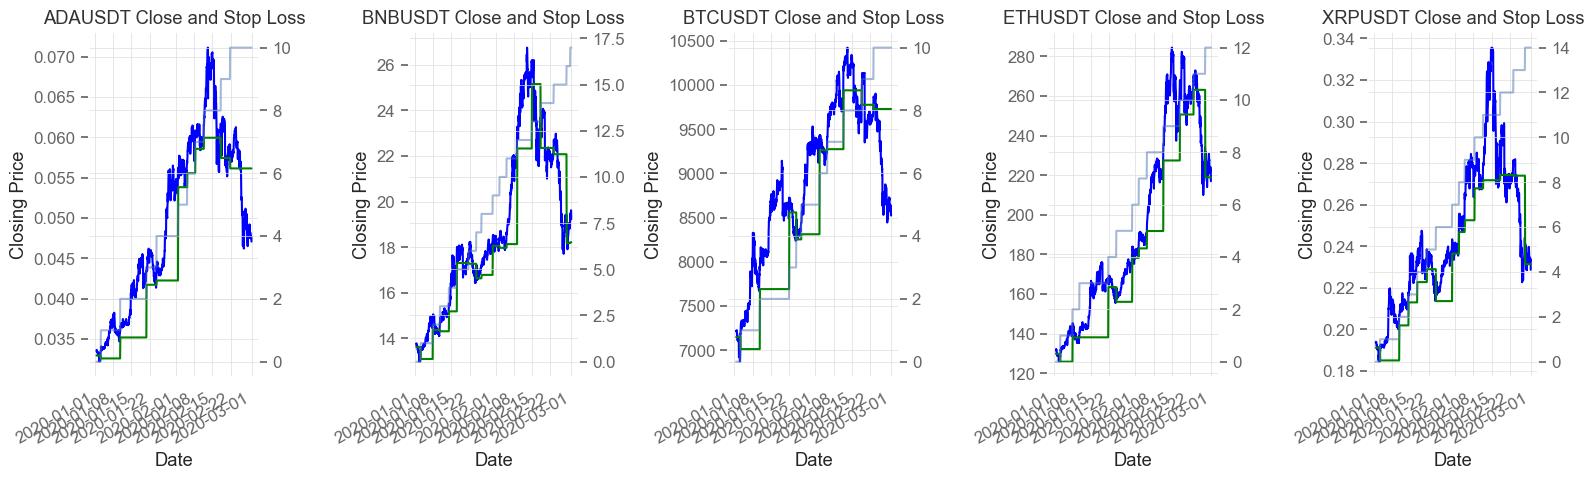

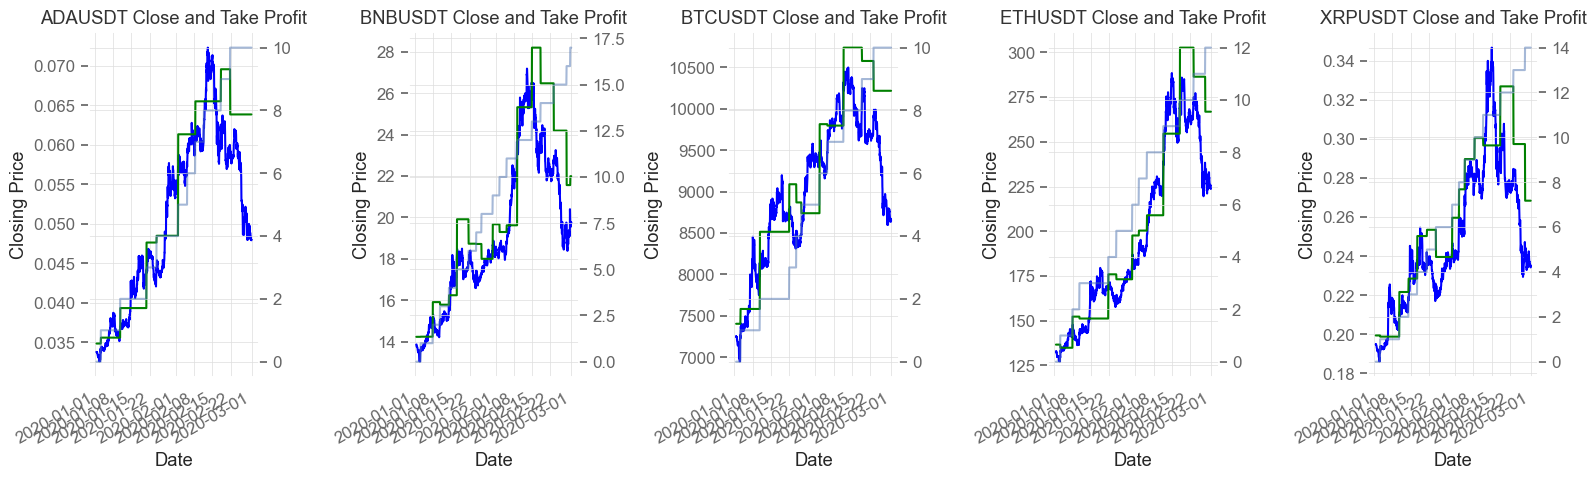

In [47]:
###### To Optimize ######
#All parameters:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling
low_freq_index = 1 #The index of the lowest frequency for the resampling
low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
max_dollar_allocation = 10000
std_window = 2
mean_window = 2
ema_window = 2
high_freq_index = 3 #The index of the highest frequency for the resampling
high_freq = all_frequency[high_freq_index] #The highest frequency for the resampling
str_length = 10
str_mult = 3
_min_pos = 0.1
_max_pos = 1
sl_type = 'atr'
sl_ind_length = 14
sl_ind_mult = 3
sl_signal_only = True
fixed_sl = True
tp_type = 'rr'
tp_mult = 2
tp_ind_length = 0
tp_signal_only = True
fixed_tp = True
max_perc_risk = 0.01




#Downsample the data
cal = Calculations()
#Generate a signal
tf = Trend_Following()

_df = tf.supertrend_signals(data, str_length, str_mult)

pos = Position(_df, _min_pos, _max_pos)
_df = pos.initialize_position()
sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
_df = sl.apply_stop_loss(fixed_sl, plot = True)
tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
_df = tp.apply_take_profit(fixed_tp, plot = True)

_df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
_df = pos.calculate_position(_df)

mt = Manage_Trade(_df)
_df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)

#########################

_df = cal.update_all(_df)



In [48]:
_df['trades'].value_counts()

trades
 0.0    6982
 0.9      57
-0.9      56
Name: count, dtype: int64

In [49]:
_df['session'].value_counts()

session
4.0     489
18.0    461
2.0     454
14.0    410
8.0     383
9.0     371
5.0     339
16.0    337
6.0     328
3.0     318
1.0     301
13.0    295
7.0     293
12.0    278
17.0    241
22.0    231
15.0    228
10.0    224
20.0    221
0.0     200
11.0    120
19.0     98
24.0     97
28.0     81
26.0     79
21.0     64
25.0     37
27.0     37
23.0     36
30.0     27
31.0     10
29.0      7
Name: count, dtype: int64

In [50]:
_df['position'].value_counts()  

position
0.1    4294
1.0    2796
Name: count, dtype: int64

In [51]:
#Calculate transaction costs on strategy returns
costs = Costs(_df, maker = 0.25, taker = 0.40)
_df = costs.apply_fees() #Applies fees on strategy returns, appears on cumulative returns when applied 

In [52]:
_df['trade_costs'].value_counts()

trade_costs
-0.00000    6982
 0.00225      57
 0.00360      56
Name: count, dtype: int64

In [53]:
df = cal.downsample(_df, low_freq)

In [54]:
#Perform coarse analysis and filtering
coarse = Coarse()
df = coarse.volume_flag(df, max_dollar_allocation)
df = coarse.sort_by_volume(df)
df = coarse.sort_by_std(df, std_window, mean_window)
fine = Fine()
df = fine.above_ema(df, ema_window)

In [55]:
#apply update_univers
df['in_universe'], current_universe = update_universe(df)

In [56]:
df.dropna()

close  creturns        high  log_return  \
date                                                                        
2020-01-02 15:00:00 ADAUSDT     0.03317  1.011897     0.03329   -0.003311   
                    BNBUSDT    13.40440  0.978559    13.43610   -0.000082   
                    BTCUSDT  7130.98000  0.993585  7152.00000   -0.000646   
                    ETHUSDT   129.59000  1.005587   129.80000    0.001699   
                    XRPUSDT     0.19054  0.989921     0.19131   -0.002516   
...                                 ...       ...         ...         ...   
2020-02-29 23:00:00 ADAUSDT     0.04710  1.436852     0.04801   -0.017051   
                    BNBUSDT    19.23000  1.403844    19.71550   -0.022028   
                    BTCUSDT  8523.61000  1.187625  8659.96000   -0.012943   
                    ETHUSDT   217.21000  1.685497   223.75000   -0.027920   
                    XRPUSDT     0.22892  1.189318     0.23472   -0.022119   

                                    low        open       price   returns  \
date                                                                        
2020-01-02 15:00:00 ADAUSDT     0.03315     0.03329     0.03317 -0.003305   
                    BNBUSDT    13.35500    13.40190    13.40440 -0.000082   
                    BTCUSDT  7120.00000  7135.59000  7130.98000 -0.000646   
                    ETHUSDT   129.36000   129.37000   129.59000  0.001701   
                    XRPUSDT     0.19030     0.19102     0.19054 -0.002513   
...                                 ...         ...         ...       ...   
2020-02-29 23:00:00 ADAUSDT     0.04707     0.04793     0.04710 -0.016907   
                    BNBUSDT    19.22960    19.66980    19.23000 -0.021787   
                    BTCUSDT  8523.55000  8634.94000  8523.61000 -0.012860   
                    ETHUSDT   217.00000   223.35000   217.21000 -0.027534   
                    XRPUSDT     0.22870     0.23404     0.22892 -0.021877   

                                   volume  volume_in_dollars  ...   htf_close  \
date                                                          ...               
2020-01-02 15:00:00 ADAUSDT  3.811639e+05       1.264321e+04  ...     0.03269   
                    BNBUSDT  3.195121e+04       4.282868e+05  ...    13.01050   
                    BTCUSDT  8.624297e+02       6.149969e+06  ...  6965.71000   
                    ETHUSDT  5.352620e+03       6.936461e+05  ...   127.19000   
                    XRPUSDT  1.301272e+06       2.479443e+05  ...     0.18750   
...                                   ...                ...  ...         ...   
2020-02-29 23:00:00 ADAUSDT  8.772487e+06       4.131841e+05  ...     0.04710   
                    BNBUSDT  1.666720e+05       3.205104e+06  ...    19.23000   
                    BTCUSDT  2.007037e+03       1.710720e+07  ...  8523.61000   
                    ETHUSDT  3.525650e+04       7.658064e+06  ...   217.21000   
                    XRPUSDT  6.806156e+06       1.558065e+06  ...     0.22892   

                               htf_volume  htf_volume_in_dollars  volume_flag  \
date                                                                            
2020-01-02 15:00:00 ADAUSDT  4.282646e+07           1.405664e+06            1   
                    BNBUSDT  9.711907e+05           1.298722e+07            1   
                    BTCUSDT  3.195148e+04           2.258280e+08            1   
                    ETHUSDT  2.137571e+05           2.749587e+07            1   
                    XRPUSDT  4.791211e+07           9.081044e+06            1   
...                                   ...                    ...          ...   
2020-02-29 23:00:00 ADAUSDT  2.197158e+08           1.063355e+07            1   
                    BNBUSDT  3.569384e+06           6.939850e+07            1   
                    BTCUSDT  3.674818e+04           3.184798e+08            1   
                    ETHUSDT  5.468667e+05           1.234982e+08            1   
    

<Axes: xlabel='date,None'>

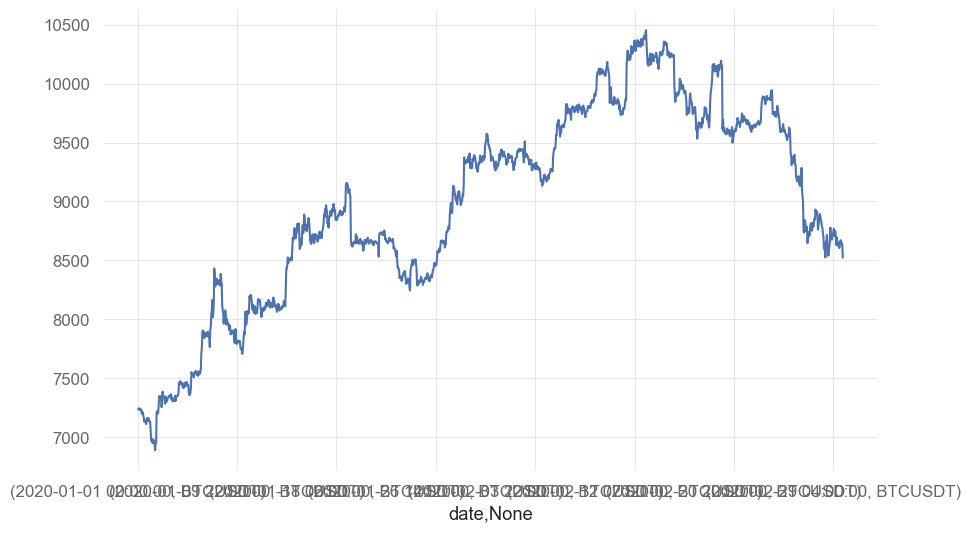

In [57]:
df.loc[(slice(None), 'BTCUSDT'), 'close'].plot()


In [58]:
df.dropna(inplace = True)

In [59]:
df = df[df['in_universe']]

#### Trading Strategy

In [60]:
all_frequency = ['1W', '1D', '4h','1h', '30min','15min', '5min', '1min'] #All possible frequencies for the resampling 

In [66]:
def trading_strategy(
        data,
        params = None,
        ###### To Optimize ######
        std_window = 20,
        mean_window = 20,
        ema_window = 20,
        str_length = 10,
        str_mult = 3,
        _min_pos = 0, #Has to be >= 0
        _max_pos = 1, #Has to be > 0
        sl_ind_length = 14,
        sl_ind_mult = 3,
        tp_mult = 2,
        ptp_mult = 1,
        ptp_exit_percent = 0.5,
        ###### Constants ######
        low_freq_index = 1, #The index of the lowest frequency for the resampling
        high_freq_index = 3, #The index of the highest frequency for the resampling
        max_perc_risk = 0.01,
        max_dollar_allocation = 10000,
        sl_type = 'atr',
        tp_type = 'rr',
        sl_signal_only = True,
        tp_signal_only = True,
        ptp_signal_only = True,
        tp_ind_length = 0,
        fixed_sl = True,
        fixed_tp = True,
        maker = 0.25,
        taker = 0.40,
        max_universe = 4
        ):
    
    if params is not None:
        if isinstance(params, list):
            std_window = params[0]
            mean_window = params[1]
            ema_window = params[2]
            str_length = params[3]
            str_mult = params[4]
            _min_pos = params[5]
            _max_pos = params[6]
            sl_ind_length = params[7]
            sl_ind_mult = params[8]
            tp_mult = params[9]
            ptp_mult = params[10]
            ptp_exit_percent = params[11]
        if isinstance(params, dict):
            std_window = params['std_window']
            mean_window = params['mean_window']
            ema_window = params['ema_window']
            str_length = params['str_length']
            str_mult = params['str_mult']
            _min_pos = params['_min_pos']
            _max_pos = params['_max_pos']
            sl_ind_length = params['sl_ind_length']
            sl_ind_mult = params['sl_ind_mult']
            tp_mult = params['tp_mult']
            ptp_mult = params['ptp_mult']
            ptp_exit_percent = params['ptp_exit_percent']
        


    if high_freq_index > low_freq_index:
        low_freq = all_frequency[low_freq_index] #The lowest frequency for the resampling
        high_freq = all_frequency[high_freq_index], #The highest frequency for the resampling
            #Generally not going to be used since we are not calling the data inside the function
    
    #########################
    
    cal = Calculations()
    tf = Trend_Following()
    #Generate a signal
    _df = tf.supertrend_signals(data.copy(), str_length, str_mult)

    pos = Position(_df, _min_pos, _max_pos)
    _df = pos.initialize_position()
    sl = Stop_Loss(_df, sl_type, sl_ind_length, sl_ind_mult, sl_signal_only)
    _df = sl.apply_stop_loss(fixed_sl, plot = False)
    tp = Take_Profit(_df, tp_type, tp_mult, tp_signal_only)
    _df = tp.apply_take_profit(fixed_tp, plot = False)
    ptp = Take_Profit(_df, tp_type, ptp_mult, ptp_signal_only, exit_percent = ptp_exit_percent)
    _df = ptp.apply_take_profit(fixed_tp, plot = False)

    _df = cal.merge_cols(_df, common = 'exit_signal', use_clip = True)
    _df = pos.calculate_position(_df)

    mt = Manage_Trade(_df)
    _df = mt.erw_actual_allocation(max_perc_risk, max_dollar_allocation)
    
    _df = cal.update_all(_df)

    #########################
    
    #Calculate transaction costs on strategy returns
    costs = Costs(_df, maker = maker, taker = taker)
    df = costs.apply_fees() #Applies fees on strategy returns, appears on cumulative returns when applied 

    #########################
    
    #Downsample the data
    df = cal.downsample(df, low_freq)

    #Perform coarse analysis and filtering
    coarse = Coarse()
    df = coarse.volume_flag(df, max_dollar_allocation)
    df = coarse.sort_by_volume(df)
    df = coarse.sort_by_std(df, std_window, mean_window)
    fine = Fine()
    df = fine.above_ema(df, ema_window)

    #apply update_univers
    df['in_universe'], current_universe = update_universe(df, max_positions = max_universe)

    df.dropna(inplace = True)

    df = df[df['in_universe']]
    
    return df



In [67]:
sample_strategy = trading_strategy(data)
'strategy' in sample_strategy.columns

True

In [68]:
sample_strategy

close  creturns        high  log_return  \
date                                                                        
2020-01-04 05:00:00 BNBUSDT    13.66420  0.997525    13.71760    0.000102   
                    BTCUSDT  7344.69000  1.023362  7369.28000    0.001339   
                    ETHUSDT   133.66000  1.037169   134.11000   -0.000075   
                    XRPUSDT     0.19259  1.000571     0.19307    0.000364   
2020-01-04 06:00:00 BNBUSDT    13.68350  0.998934    13.69700    0.001411   
...                                 ...       ...         ...         ...   
2020-02-29 08:00:00 ETHUSDT   228.57000  1.773648   230.00000   -0.002665   
                    XRPUSDT     0.23899  1.241635     0.23939    0.000377   
2020-02-29 09:00:00 BNBUSDT    18.88590  1.378724    19.11890   -0.011848   
                    ETHUSDT   225.49000  1.749748   228.57000   -0.013567   
                    XRPUSDT     0.23523  1.222101     0.23904   -0.015858   

                                    low        open       price   returns  \
date                                                                        
2020-01-04 05:00:00 BNBUSDT    13.64880    13.66280    13.66420  0.000102   
                    BTCUSDT  7325.00000  7334.59000  7344.69000  0.001340   
                    ETHUSDT   133.40000   133.68000   133.66000 -0.000075   
                    XRPUSDT     0.19240     0.19255     0.19259  0.000364   
2020-01-04 06:00:00 BNBUSDT    13.65660    13.66650    13.68350  0.001412   
...                                 ...         ...         ...       ...   
2020-02-29 08:00:00 ETHUSDT   227.85000   229.20000   228.57000 -0.002662   
                    XRPUSDT     0.23780     0.23893     0.23899  0.000377   
2020-02-29 09:00:00 BNBUSDT    18.88000    19.11100    18.88590 -0.011779   
                    ETHUSDT   225.00000   228.57000   225.49000 -0.013475   
                    XRPUSDT     0.23436     0.23899     0.23523 -0.015733   

                                   volume  volume_in_dollars  ...   htf_close  \
date                                                          ...               
2020-01-04 05:00:00 BNBUSDT  5.297686e+04       7.238864e+05  ...    13.80920   
                    BTCUSDT  1.306739e+03       9.597591e+06  ...  7354.11000   
                    ETHUSDT  5.335128e+03       7.130932e+05  ...   134.20000   
                    XRPUSDT  1.460082e+06       2.811973e+05  ...     0.19305   
2020-01-04 06:00:00 BNBUSDT  5.500837e+04       7.527070e+05  ...    13.80920   
...                                   ...                ...  ...         ...   
2020-02-29 08:00:00 ETHUSDT  1.556930e+04       3.558676e+06  ...   217.21000   
                    XRPUSDT  2.213010e+06       5.288874e+05  ...     0.22892   
2020-02-29 09:00:00 BNBUSDT  9.007506e+04       1.701149e+06  ...    19.23000   
                    ETHUSDT  2.743457e+04       6.186221e+06  ...   217.21000   
                    XRPUSDT  5.339575e+06       1.256028e+06  ...     0.22892   

                               htf_volume  htf_volume_in_dollars  volume_flag  \
date                                                                            
2020-01-04 05:00:00 BNBUSDT  1.231281e+06           1.688657e+07            1   
                    BTCUSDT  2.998797e+04           2.197767e+08            1   
                    ETHUSDT  1.842762e+05           2.462182e+07            1   
                    XRPUSDT  3.423966e+07           6.591874e+06            1   
2020-01-04 06:00:00 BNBUSDT  1.231281e+06           1.688657e+07            1   
...                                   ...                    ...          ...   
2020-02-29 08:00:00 ETHUSDT  5.468667e+05           1.234982e+08            1   
                    XRPUSDT  1.046021e+08           2.469854e+07            1   
2020-02-29 09:00:00 BNBUSDT  3.569384e+06           6.939850e+07            1   
                    ETHUSDT  5.468667e+05           1.234982e+08            1   
    

In [69]:
# Define parameter space for optimization
param_space = {
    'std_window': Integer(5, 30),
    'mean_window': Integer(5, 30),
    'ema_window': Integer(5, 100),
    'str_length': Integer(5, 50),
    'str_mult': Integer(1, 5),
    '_min_pos': Real(0, 0.5),
    '_max_pos': Real(0, 1),
    'sl_ind_length': Integer(5, 50),
    'sl_ind_mult': Real(0.5, 5),
    'tp_mult': Integer(2, 7),
    'ptp_mult': Real(1, 2),
    'ptp_exit_percent': Real(0.1, 1)
}

In [89]:
wfo = WFO(data, 
            trading_strategy, 
            param_space, 
            train_size=2000, 
            test_size=2000, 
            step_size=2000, 
            optimize_fn="gp", 
            objective='multiple', 
            opt_freq='custom')

all_performance, all_results = wfo.walk_forward_optimization()

1.1400520317198686
1.0006647748819808
1.3211988532292642
1.4046970841583806
1.4255796217663677
1.0954198596297782
1.4578060762558533
1.7680740288886823
1.2972078911255125
1.0905567730008632
{'std_window': 22, 'mean_window': 22, 'ema_window': 61, 'str_length': 17, 'str_mult': 3, '_min_pos': 0.19146343737689497, '_max_pos': 0.971712095389104, 'sl_ind_length': 43, 'sl_ind_mult': 3.7477828452419297, 'tp_mult': 3, 'ptp_mult': 1.256068322761324, 'ptp_exit_percent': 0.1363902305845882}
[22, 22, 61, 17, 3, 0.19146343737689497, 0.971712095389104, 43, 3.7477828452419297, 3, 1.256068322761324, 0.1363902305845882]
Out-of-sample performance: 1.5542544875099134
1.0140451585068266
1.0001145618057052
1.3105306963384413
1.0216177780565743
1.2557556010484061
1.0623443307903355
1.3430375865183348
1.5542544875099134
1.1518924342129189
1.0486409028109247
{'std_window': 22, 'mean_window': 22, 'ema_window': 61, 'str_length': 17, 'str_mult': 3, '_min_pos': 0.19146343737689497, '_max_pos': 0.971712095389104, '

In [90]:
np.mean(all_performance)

1.1590088589142322

In [91]:
all_results

close  creturns         high  log_return  \
date                                                                          
2020-01-25 12:00:00 BNBUSDT     16.72690  1.221111     16.87850   -0.006371   
2020-01-25 13:00:00 ADAUSDT      0.04348  1.326419      0.04372    0.011799   
                    BNBUSDT     16.82410  1.228207     16.90500    0.005794   
2020-01-25 14:00:00 ADAUSDT      0.04314  1.316046      0.04366   -0.007850   
                    BNBUSDT     16.86270  1.231025     16.93380    0.002292   
...                                  ...       ...          ...         ...   
2020-12-16 12:00:00 ETHUSDT    592.81000  4.600062    598.82000   -0.001635   
2020-12-16 13:00:00 ADAUSDT      0.15928  4.859060      0.15951    0.047507   
                    BNBUSDT     29.72090  2.169710     29.74810    0.013420   
                    BTCUSDT  20319.51000  2.831190  20450.00000    0.027780   
                    ETHUSDT    609.19000  4.727167    609.89000    0.027256   

                                     low         open         price   returns  \
date                                                                            
2020-01-25 12:00:00 BNBUSDT     16.69490     16.83480     16.726900 -0.006350   
2020-01-25 13:00:00 ADAUSDT      0.04293      0.04295      0.043480  0.011869   
                    BNBUSDT     16.70920     16.72550     16.824100  0.005811   
2020-01-25 14:00:00 ADAUSDT      0.04310      0.04350      0.043140 -0.007820   
                    BNBUSDT     16.82050     16.82050     16.862700  0.002294   
...                                  ...          ...           ...       ...   
2020-12-16 12:00:00 ETHUSDT    590.78000    593.79000    598.689177 -0.001634   
2020-12-16 13:00:00 ADAUSDT      0.15169      0.15188      0.159280  0.048654   
                    BNBUSDT     29.29550     29.31790     29.720900  0.013511   
                    BTCUSDT  19762.80000  19762.80000  20319.510000  0.028169   
                    ETHUSDT    592.81000    592.81000    609.190000  0.027631   

                                   volume  volume_in_dollars  ...  \
date                                                          ...   
2020-01-25 12:00:00 BNBUSDT  3.653446e+04       6.111083e+05  ...   
2020-01-25 13:00:00 ADAUSDT  6.569228e+06       2.856300e+05  ...   
                    BNBUSDT  2.550681e+04       4.291291e+05  ...   
2020-01-25 14:00:00 ADAUSDT  2.434023e+06       1.050038e+05  ...   
                    BNBUSDT  2.988835e+04       5.039983e+05  ...   
...                                   ...                ...  ...   
2020-12-16 12:00:00 ETHUSDT  6.241895e+04       3.700258e+07  ...   
2020-12-16 13:00:00 ADAUSDT  3.335599e+07       5.312942e+06  ...   
                    BNBUSDT  1.039581e+05       3.089729e+06  ...   
                    BTCUSDT  1.151006e+04       2.338788e+08  ...   
                    ETHUSDT  1.072957e+05       6.536349e+07  ...   

                             SUPERT_33_3.0  SUPERTd_33_3.0  SUPERTl_33_3.0  \
date                                                                         
2020-01-25 12:00:00 BNBUSDT            NaN             NaN             NaN   
2020-01-25 13:00:00 ADAUSDT            NaN             NaN             NaN   
                    BNBUSDT            NaN             NaN             NaN   
2020-01-25 14:00:00 ADAUSDT            NaN             NaN             NaN   
                    BNBUSDT            NaN             NaN             NaN   
...                                    ...             ...             ...   
2020-12-16 12:00:00 ETHUSDT            NaN             NaN             NaN   
2020-12-16 13:00:00 ADAUSDT            NaN             NaN             NaN   
                    BNBUSDT            NaN             NaN             NaN   
                    BTCUSDT            NaN             NaN             NaN   
                    ETHUSDT            NaN             NaN             NaN   

                             SUPERTs_33_

In [92]:
import quantstats_lumi as qs

In [93]:
qs.stats.sharpe(all_results['strategy'].apply(np.exp) - 1)

0.5346397006818427

<Axes: xlabel='date,None'>

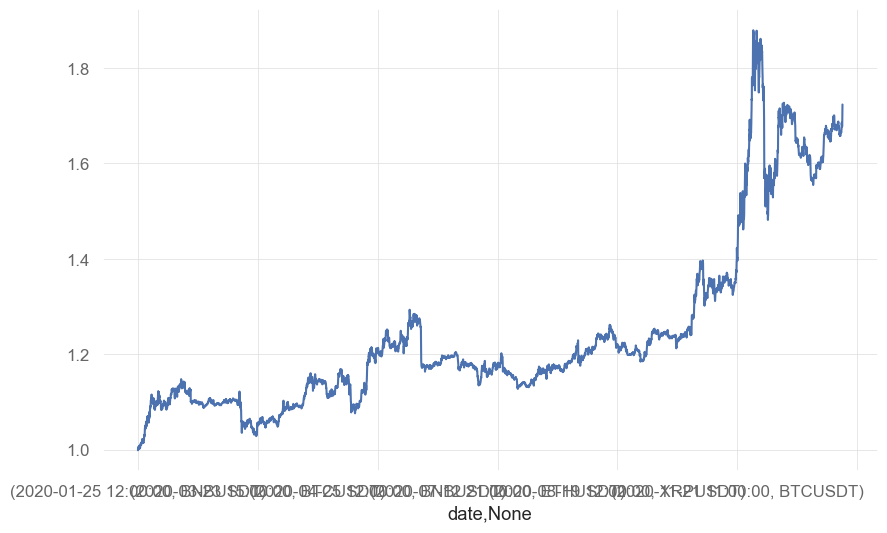

In [94]:
all_results['cstrategy'] = creturns = (all_results['strategy'] * (1/4)).cumsum().apply(np.exp)
creturns.plot()

In [ ]:
def optimize_sizes(data, trading_strategy, param_space):
    best_performance = -np.inf
    for train_size in range(1000, 3001, 500):  # Adjust the step size as needed
        for test_size in range(1000, 3001, 500):
            for step_size in range(1000, 3001, 500):
                wfo = WFO(data, 
                        trading_strategy, 
                        param_space, 
                        train_size=train_size, 
                        test_size=test_size, 
                        step_size=step_size, 
                        optimize_fn="gp", 
                        objective='sharpe', 
                        opt_freq='custom')
                print(f"Train size: {train_size}, Test size: {test_size}, Step size: {step_size}")
                all_performance, all_results = wfo.walk_forward_optimization()
                if np.mean(all_performance) > best_performance:
                    best_performance = np.mean(all_performance)
                    best_train_size = train_size
                    best_test_size = test_size
                    best_step_size = step_size
                    best_results = all_results
                print(f"Mean performance: {np.mean(all_performance)}")

    return best_train_size, best_test_size, best_step_size, best_results, best_performance

optimize_sizes(data, trading_strategy, param_space)
